<a href="https://colab.research.google.com/github/makkyo-git/python-collection/blob/mabo/LSGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
# バージョン指定時にコメントアウト
#!pip3 install torch==1.7.0
#!pip3 install torchvision==0.8.1

import torch
import torchvision
#バージョンの確認
print(torch.__version__)
print(torchvision.__version__)



1.12.1+cu113
0.13.1+cu113


In [ ]:
# Google Driveにマウント
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
%mkdir GAN

In [ ]:
# パッケージのインポート
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchsummary


In [ ]:
# datasetは、自分が読み込ませたい画像のパス(ただし、階層は、直前の一つ下にすること)を書く
dataroot = "/content/drive/MyDrive/dataset"

# データローダーのワーカー数
workers = 5

#トレーニングのバッチサイズ
batch_size = 32

#トレーニング画像の空間サイズ
# 全ての画像はトランスフォーマートランスフォーマーを使用してこのサイズに変更されます

nch_g = 64
nch_d = 64

#　潜在ベクトル潜在ベクトル z のサイズ (つまり、ジェネレータ入力のサイズ)
nz = 100

# エポック数
n_epoch = 10000

# 学習率
lr = 0.002

# Adam オプティマイザオプティマイザのbeta1ハイパーパラメータ
beta1 = 0.5
outf = './result2_あ_10000epoch-LSGAN'

display_interval = 100
save_fake_image_interval = 1500
plt.rcParams['figure.figsize'] = 10, 6




In [ ]:
# 保存先ディレクトリを作成
try:
    os.makedirs(outf, exist_ok=True)
except OSError as error:
    print(error)
    pass

# 乱数のシード(種)を固定を固定
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

**データセットの作成**

In [ ]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                              transforms.Resize(64),
                              transforms.CenterCrop(64),
                              transforms.ToTensor(),
                              # -1〜1に値域に変更
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                           ]))

In [ ]:
# 画像配列の確認
dataset[0][0].shape


torch.Size([3, 64, 64])

In [ ]:
len(dataset)

600

In [ ]:
# データローダーを作成する
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True, num_workers=workers)

# 実行するデバイスを決定する
device = torch.device("cuda:0" if torch.cuda. is_available() else "cpu")
print(device)

cpu


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**ネットワークの定義**

In [ ]:
# Generator (生成器)

class Generator(nn.Module):
    def __init__(self, nz=100, nch_g=64, nch=3):
        super(Generator, self).__init__()
        self.layers = nn.ModuleDict({
            'layer0': nn.Sequential(
                nn.ConvTranspose2d(nz, nch_g * 8, 4, 1, 0),
                nn.BatchNorm2d(nch_g * 8),
                nn.ReLU()
            ), # (100, 1, 1) -> (512, 4, 4)
            'layer1': nn.Sequential(
                nn.ConvTranspose2d(nch_g * 8, nch_g * 4, 4, 2, 1),
                nn.BatchNorm2d(nch_g * 4),
                nn.ReLU()
            ), # (512, 4, 4) -> (256, 8, 8)
            'layer2': nn.Sequential(
                nn.ConvTranspose2d(nch_g * 4, nch_g * 2, 4, 2, 1),
                nn.BatchNorm2d(nch_g * 2),
                nn.ReLU()
            ), # (256, 8, 8) -> (128, 16, 16)
            'layer3': nn.Sequential(
                nn.ConvTranspose2d(nch_g * 2, nch_g, 4, 2, 1),
                nn.BatchNorm2d(nch_g),
                nn.ReLU()
            ), # (128, 16, 16) -> (64, 32, 32)
            'layer4': nn.Sequential(
                nn.ConvTranspose2d(nch_g, nch, 4, 2, 1),
                nn.Tanh()
            )  # (64, 32, 32) -> (3, 64, 64)
        })
    def forward(self, z):
        for layer in self.layers.values():
            z = layer(z)
        return z

In [ ]:
# Discriminator (識別器)

class Discriminator(nn.Module):
    def __init__(self, nch=3, nch_d=64):
        super(Discriminator, self).__init__()
        self.layers = nn.ModuleDict({
            'layer0': nn.Sequential(
                nn.Conv2d(nch, nch_d, 4, 2, 1),
                nn.BatchNorm2d(nch_d),
                nn.LeakyReLU(negative_slope=0.2)
            ), # (3, 64, 64) -> (64, 32, 32)
            'layer1': nn.Sequential(
                nn.Conv2d(nch_d, nch_d * 2, 4, 2, 1),
                nn.BatchNorm2d(nch_d*2),
                nn.LeakyReLU(negative_slope=0.2)
            ), # (64, 32, 32) -> (128, 16, 16)
            'layer2': nn.Sequential(
                nn.Conv2d(nch_d * 2, nch_d * 4, 4, 2, 1),
                nn.BatchNorm2d(nch_d*4),
                nn.LeakyReLU(negative_slope=0.2)
            ), #(128, 16, 16) -> (256, 8, 8)
            'layer3': nn.Sequential(
                nn.Conv2d(nch_d * 4, nch_d * 8, 4, 2, 1),
                nn.BatchNorm2d(nch_d*8),
                nn.LeakyReLU(negative_slope=0.2)
            ), # (256, 8, 8) -> (512, 4, 4)
            'layer4': nn.Sequential( nn.Conv2d(nch_d * 8, 1, 4, 1, 0)
            # (512, 4 ,4) -> (1, 1, 1)
            # 勾配消失を防ぐ為ためにためにSigmoidは使わない
            )
        }) 
    def forward(self, x):
        for layer in self.layers.values():
            x = layer(x)
            x = x.squeeze()

        return x

In [ ]:
# Generator(生成器)ととDiscriminator(識別器)の重みの初期化重みの初期化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
# ジェネレーターを生成します
netG = Generator(nz=nz, nch_g=nch_g).to(device)

#必要に応じてGPUを使用します
# if (device.type == 'cuda' ) and (ngpu > 1):
#     netG = nn.DataParallel(netG, list(range(ngpu)))

# weights_init関数を適応して、全ての重み重みを平均「0」、標準偏差「0.02」でランダムに初期化します。。
netG.apply(weights_init)

# モデルを出力します
print(netG)

Generator(
  (layers): ModuleDict(
    (layer0): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer4): Sequential(
      (0): ConvTranspose2d(64, 3, ker

In [ ]:
# Create the Discriminator
# 識別器を生成します
netD = Discriminator(nch_d=nch_d).to(device)

# Handle multi-gpu if desired
# 必要に応じて必要に応じてGPUを使用します
# if (device.type == 'cuda') and (ngpu > 1):
#     netD = nn.DataPararellel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
# to mean=0, stdev=0.2.
# weights_init関数を適応して、全ての重みを平均「0」、標準偏差「0.02」でランダムに初期化します。。
netD.apply(weights_init)

#Print the model
# モデルを出力します
print(netD)

Discriminator(
  (layers): ModuleDict(
    (layer0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (layer1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (layer2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (layer3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0

**学習の実行**

In [ ]:
# 損失関数は平均二乗誤差平均二乗誤差! DCGANと違う
criterion = nn.MSELoss()

# ジェネレータの進行を視覚化するために使用する潜在ベクトルを作成します
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device) # save_fake_image用ノイズ (固定)

# トレーニング中に本物のラベルと偽のラベルのルールを設定します。
# real_label = 1.
# fake_label = 0.

# G と D にに Adam オプチマイザを設定する
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# トレーニングループ

# 進捗状況を追跡するためのリスト
Loss_D_list, Loss_G_list = [],[]

# エポック毎のループ
for epoch in range(n_epoch):
    for itr, data in enumerate(dataloader):
        real_image = data[0].to(device) # 本物画像
        sample_size = real_image.size(0) # 画像枚数
        noise = torch.randn(sample_size, nz, 1, 1, device=device) # 入力ベクトル生成入力(正規分布ノイズ)
        real_target = torch.full((sample_size,), random.uniform(1, 1), device=device) # 本物ラベル
        fake_target = torch.full((sample_size,), random.uniform(0, 0), device=device) # 偽物ラベル偽物ラベル


        # Generator→Discriminatorの順ににパラメータ更新

        #----------- Update Generator ------------
        netG.zero_grad()
        fake_image = netG(noise) # Generatorから得られた偽画像
        output = netD(fake_image) # 更新した Discriminatorで、偽物画像を判定
        errG = criterion(output,real_target) # 偽物画像の判定結果
        errG.backward(retain_graph = True) # 誤差逆伝播
        D_G_z2 = output.mean().item() # outputの平均平均 D_G_z2 を計算 (後にログ出力に使用)

        optimizerG.step() # Generatorのパラメータ更新

        # --------Update Discriminator -----------
        netD.zero_grad() # 勾配の初期化
        fake_image = netG(noise) # Generatorから得られた偽画像
        output = netD(real_image) # Discriminatorが行った、本物画像の判定結果
        errD_real = criterion(output,real_target) # 本物画像の判定結果と本物ラベルとの二乗誤差二乗誤差
        D_x = output.mean().item() # outputの平均 D_x を計算計算 (後にログ出力に使用)

        output = netD(fake_image.detach()) # Discriminatorが行った、偽物画像の判定結果

        errD_fake = criterion(output,fake_target) # 偽物画像の判定結果と偽物画像との二乗誤差偽物画像との二乗誤差
        D_G_z1 = output.mean().item() # outputの平均 D_G_z1 を計算 (後でログ出力に使用)

        errD = errD_real + errD_fake # Discriminator 全体の損失
        errD.backward(retain_graph = True) # 誤差逆伝播
        optimizerD.step() # Discriminatorのパラメーターを更新

        # トレーニング統計を出力します
        if itr % 5 == 0:
            print('[{}/{}][{}/{}] Loss_D: {:.3f} Loss_G: {:.3f} D(x): {:.3f} D(G(z)): {:.3f}/{:.3f}'
            .format(epoch + 1, n_epoch, itr + 1, len(dataloader),
                    errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # 後でプロットするために損失を保存します
        Loss_D_list.append(errD.item())
        Loss_G_list.append(errG.item())

        ########################
        # 確認用画像の生成
        ########################
        if (epoch + 1) % 2 == 0:
            fake_image = netG(fixed_noise)
            vutils.save_image(fake_image.detach(),'./GAN/{:03d}random_{:03d}.png'.format(itr, epoch + 1), normalize=True, nrow=8)

        ########################
        # モデルの保存
        ########################
        if (epoch + 1) % 2 == 0: # 5エポック毎にモデルを保存するモデルを保存する
            torch.save(netG.state_dict(), '{}/netG_epoch_{}.pth'.format(outf, epoch + 1))
            torch.save(netD.state_dict(), '{}/netD_epoch_{}.pth'.format(outf, epoch + 1))

[1/10000][1/19] Loss_D: 150.390 Loss_G: 1.747 D(x): 0.809 D(G(z)): 11.300/0.155
[1/10000][6/19] Loss_D: 25.175 Loss_G: 3.821 D(x): 5.027 D(G(z)): 2.254/-0.744
[1/10000][11/19] Loss_D: 2.674 Loss_G: 7.076 D(x): 1.715 D(G(z)): 1.337/-1.616
[1/10000][16/19] Loss_D: 0.560 Loss_G: 1.834 D(x): 1.158 D(G(z)): 0.364/-0.345
[2/10000][1/19] Loss_D: 0.426 Loss_G: 4.801 D(x): 0.795 D(G(z)): -0.294/-1.166
[2/10000][6/19] Loss_D: 11.591 Loss_G: 8.193 D(x): 0.274 D(G(z)): 3.228/-1.827
[2/10000][11/19] Loss_D: 1.141 Loss_G: 0.621 D(x): 1.163 D(G(z)): 0.692/0.525
[2/10000][16/19] Loss_D: 0.511 Loss_G: 2.549 D(x): 0.564 D(G(z)): -0.362/-0.556
[3/10000][1/19] Loss_D: 0.226 Loss_G: 1.014 D(x): 1.183 D(G(z)): 0.188/0.056
[3/10000][6/19] Loss_D: 0.222 Loss_G: 1.475 D(x): 0.830 D(G(z)): -0.065/-0.196
[3/10000][11/19] Loss_D: 0.385 Loss_G: 2.066 D(x): 0.550 D(G(z)): -0.272/-0.422
[3/10000][16/19] Loss_D: 0.261 Loss_G: 1.601 D(x): 0.743 D(G(z)): -0.054/-0.233
[4/10000][1/19] Loss_D: 0.225 Loss_G: 1.038 D(x): 0

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(Loss_G_list,label="G")
plt.plot(Loss_D_list,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

NameError: ignored

In [ ]:
# ネットワーク定義
netG = Generator(nz=100, nch_g=64).cpu().eval()

# 重みの読み込み
netG.load_state_dict(torch.load("/content/result2_あ_10000epoch-LSGAN/netG_epoch_65.pth"))

<All keys matched successfully>

In [ ]:
# fake_image作成
noise = torch.randn(50, 100, 1, 1)# sample_size, nz, 1, 1
y = netG(noise)

transform = transforms.Grayscale()
y_transform = transform(y)

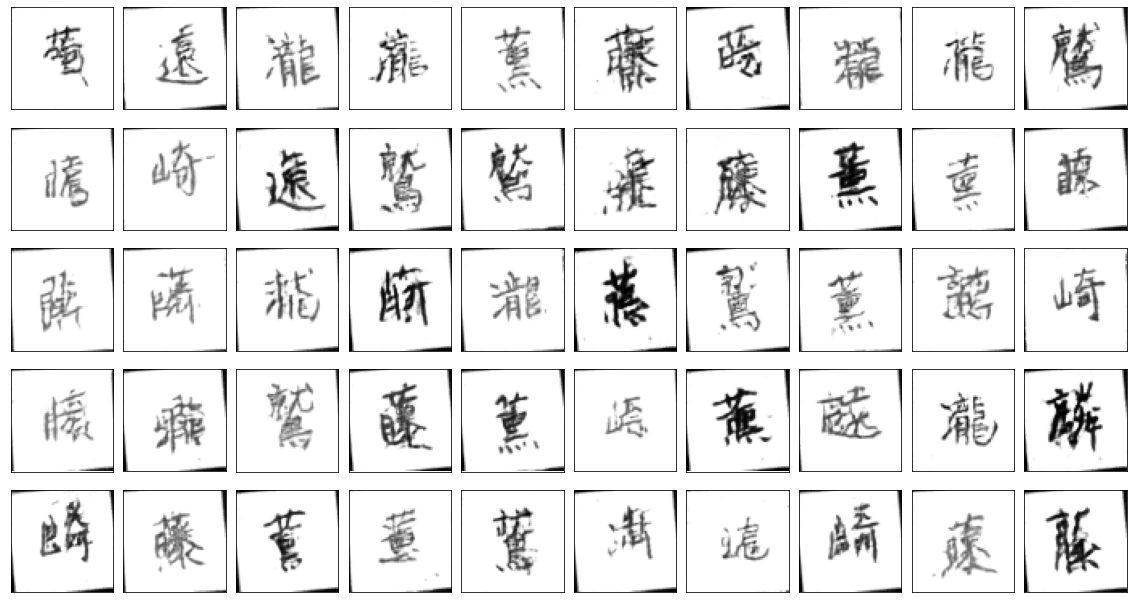

In [ ]:
fig = plt.figure(figsize=(20,20))
plt.subplots_adjust(wspace=0.1, hspace=-0.8)
for i in range(50):
    ax = fig.add_subplot(5, 10, i+1, xticks=[], yticks=[])
    ax.imshow(y_transform[i,].view(64,64).cpu().detach(), "gray")